# Initialization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import attrs
import importlib
import pickle

import tensorflow as tf
import keras

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
root_logdir = os.path.join(os.curdir, "logs")

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

def get_run_logdir(name=None):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") + f"- {name}"
    return os.path.join(root_logdir, run_id)

## Data initialization

In [3]:
dataset = pd.read_csv("data/train.csv")

In [4]:
dataset

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [5]:
dataset.shape

(10407, 4)

In [6]:
dataset["label"].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

## Data preparation

In [7]:
y = dataset["label"]
X = dataset.drop(columns=["label", "variety", "age"])

In [8]:
X.shape

(10407, 1)

In [9]:
y_labels = y.unique()
y_labels

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype=object)

In [10]:
label_transformer = LabelEncoder()

In [11]:
X_train, X_test, X_valid, y_train, y_test, y_valid = attrs.split_dataset(X, y)

In [12]:
y_train, y_test, y_valid = label_transformer.fit_transform(y_train), label_transformer.fit_transform(y_test), label_transformer.fit_transform(y_valid)

e:\Program files\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_valid.shape, y_valid.shape)

(((7492, 160, 120, 3), (7492,)),
 ((1041, 160, 120, 3), (1041,)),
 ((1874, 160, 120, 3), (1874,)))

# Training

## Model 1

In [14]:
model_1 = keras.Sequential()
model_1.add(keras.layers.Conv2D(48, 3, activation='relu', padding="same", input_shape=(X_train.shape[1], X_train.shape[2], 3)))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.MaxPool2D(2))

model_1.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_1.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.MaxPool2D(2))

model_1.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_1.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_1.add(keras.layers.MaxPool2D(2))

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(384, activation="relu"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dropout(0.2))

model_1.add(keras.layers.Dense(192, activation="relu"))
model_1.add(keras.layers.Dense(96, activation="relu"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.Dense(48, activation="relu"))
model_1.add(keras.layers.Dense(10, activation="softmax"))

In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/model_1_best.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("model_1"))
earlystopping_cb = keras.callbacks.EarlyStopping(patience=25)

model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model_1.fit(X_train, y_train, 
                        epochs=200, 
                        batch_size=24,
                        validation_data=(X_valid, y_valid), 
                        callbacks=[checkpoint_cb, tensorboard_cb, earlystopping_cb])

Epoch 1/200
313/313 [==============================] - 36s 101ms/step - loss: 1.9003 - accuracy: 0.3445 - val_loss: 3.5354 - val_accuracy: 0.2001
Epoch 2/200
313/313 [==============================] - 30s 96ms/step - loss: 1.5082 - accuracy: 0.4871 - val_loss: 1.3459 - val_accuracy: 0.5395
Epoch 3/200
313/313 [==============================] - 28s 90ms/step - loss: 1.3626 - accuracy: 0.5400 - val_loss: 2.1291 - val_accuracy: 0.3549
Epoch 4/200
313/313 [==============================] - 30s 96ms/step - loss: 1.0337 - accuracy: 0.6591 - val_loss: 1.2252 - val_accuracy: 0.5918
Epoch 5/200
313/313 [==============================] - 28s 90ms/step - loss: 0.8532 - accuracy: 0.7240 - val_loss: 1.2710 - val_accuracy: 0.6110
Epoch 6/200
313/313 [==============================] - 28s 89ms/step - loss: 0.6528 - accuracy: 0.7866 - val_loss: 1.6727 - val_accuracy: 0.5080
Epoch 7/200
313/313 [==============================] - 30s 96ms/step - loss: 0.5173 - accuracy: 0.8300 - val_loss: 0.8199 - val_a

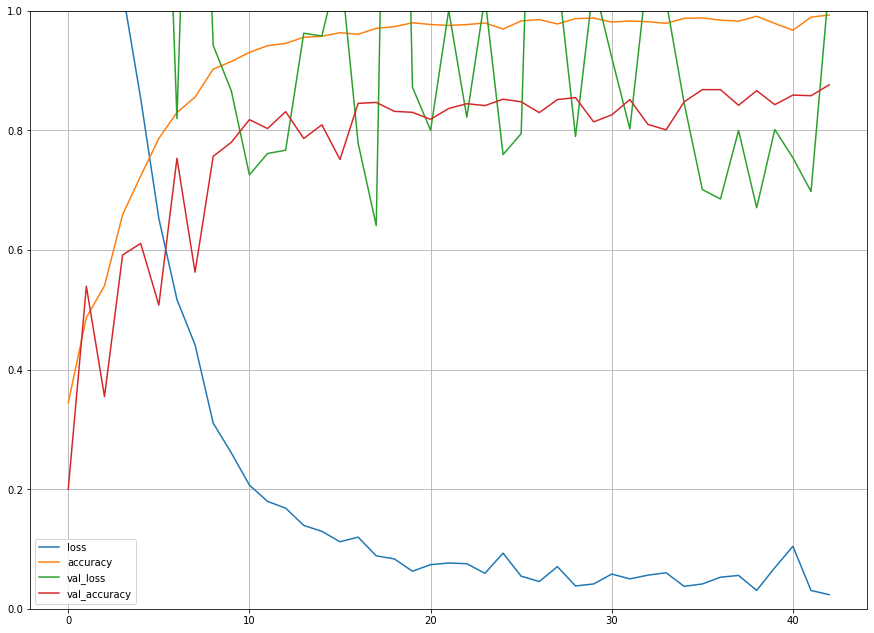

In [17]:
pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
model_1.save("models/model_1.h5")
model_1.evaluate(X_test, y_test)

33/33 [==============================] - 2s 43ms/step - loss: 0.6532 - accuracy: 0.8751


[0.6532226204872131, 0.8751201033592224]

In [19]:
model_1_ = keras.models.load_model("models/model_1_best.h5")
model_1_.evaluate(X_test, y_test)

33/33 [==============================] - 1s 29ms/step - loss: 0.7044 - accuracy: 0.8386


[0.7044097185134888, 0.8386167287826538]

In [31]:
attrs.clear_session()

## Model 2

In [14]:
model_2 = keras.Sequential()
model_2.add(keras.layers.Conv2D(48, 3, activation='relu', padding="same", input_shape=(X_train.shape[1], X_train.shape[2], 3)))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.MaxPool2D(2))

model_2.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_2.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.MaxPool2D(2))

model_2.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_2.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.MaxPool2D(2))

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(384, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dropout(0.2))

model_2.add(keras.layers.Dense(192, activation="relu"))
model_2.add(keras.layers.Dense(192, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dropout(0.2))
model_2.add(keras.layers.Dense(96, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dense(96, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dense(48, activation="relu"))
model_2.add(keras.layers.Dense(10, activation="softmax"))

In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/model_2_best.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("model_2"))
earlystopping_cb = keras.callbacks.EarlyStopping(patience=30)

model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model_2.fit(X_train, y_train, 
                        epochs=200, 
                        batch_size=24,
                        validation_data=(X_valid, y_valid), 
                        callbacks=[checkpoint_cb, tensorboard_cb, earlystopping_cb])

Epoch 1/200
313/313 [==============================] - 40s 106ms/step - loss: 1.9444 - accuracy: 0.3246 - val_loss: 2.0078 - val_accuracy: 0.3799
Epoch 2/200
313/313 [==============================] - 31s 100ms/step - loss: 1.4995 - accuracy: 0.4869 - val_loss: 1.7068 - val_accuracy: 0.4344
Epoch 3/200
313/313 [==============================] - 32s 102ms/step - loss: 1.3068 - accuracy: 0.5631 - val_loss: 1.5784 - val_accuracy: 0.4835
Epoch 4/200
313/313 [==============================] - 31s 100ms/step - loss: 1.0977 - accuracy: 0.6335 - val_loss: 1.1071 - val_accuracy: 0.6606
Epoch 5/200
313/313 [==============================] - 30s 96ms/step - loss: 0.9797 - accuracy: 0.6814 - val_loss: 1.1481 - val_accuracy: 0.6254
Epoch 6/200
313/313 [==============================] - 30s 96ms/step - loss: 0.8033 - accuracy: 0.7447 - val_loss: 1.3237 - val_accuracy: 0.5731
Epoch 7/200
313/313 [==============================] - 32s 101ms/step - loss: 0.5790 - accuracy: 0.8185 - val_loss: 0.7879 - v

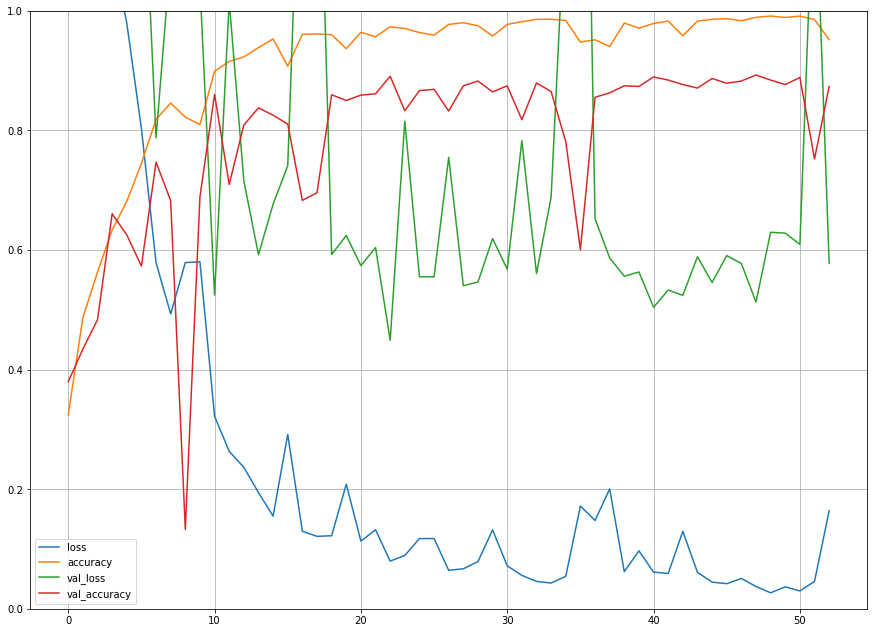

In [17]:
pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
model_2.save("models/model_2.h5")
model_2.evaluate(X_test, y_test)

33/33 [==============================] - 2s 45ms/step - loss: 0.5821 - accuracy: 0.8790


[0.5820742249488831, 0.878962516784668]

In [19]:
model_2_ = keras.models.load_model("models/model_2_best.h5")
model_2_.evaluate(X_test, y_test)

33/33 [==============================] - 1s 27ms/step - loss: 0.4290 - accuracy: 0.8905


[0.42904868721961975, 0.890489935874939]

In [20]:
attrs.clear_session()

### Data augmentation

In [17]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [18]:
X_train_total = np.concatenate([X_train, X_valid])
y_train_total = np.concatenate([y_train, y_valid])
X_train_total.shape, y_train_total.shape

((9366, 160, 120, 3), (9366,))

In [19]:
datagen.fit(X_train_total)

In [35]:
model_2_aug = keras.models.clone_model(model_2)

In [36]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/model_2_aug_best.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("model_2_aug"))
earlystopping_cb = keras.callbacks.EarlyStopping(patience=30)

model_2_aug.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [37]:
history = model_2_aug.fit(datagen.flow(X_train_total, y_train_total, batch_size=24, subset='training'),
                        epochs=200,
                        batch_size=24,
                        validation_data=datagen.flow(X_train_total, y_train_total, batch_size=8, subset='validation'), 
                        callbacks=[checkpoint_cb, tensorboard_cb, earlystopping_cb])

Epoch 1/200
313/313 [==============================] - 42s 124ms/step - loss: 2.1286 - accuracy: 0.2544 - val_loss: 2.0371 - val_accuracy: 0.2872
Epoch 2/200
313/313 [==============================] - 40s 126ms/step - loss: 1.8320 - accuracy: 0.3531 - val_loss: 1.8204 - val_accuracy: 0.3476
Epoch 3/200
313/313 [==============================] - 38s 121ms/step - loss: 1.7148 - accuracy: 0.3964 - val_loss: 2.1546 - val_accuracy: 0.2712
Epoch 4/200
313/313 [==============================] - 39s 124ms/step - loss: 1.6005 - accuracy: 0.4441 - val_loss: 1.6858 - val_accuracy: 0.4159
Epoch 5/200
313/313 [==============================] - 37s 117ms/step - loss: 1.5308 - accuracy: 0.4658 - val_loss: 1.8525 - val_accuracy: 0.3924
Epoch 6/200
313/313 [==============================] - 39s 124ms/step - loss: 1.5112 - accuracy: 0.4710 - val_loss: 1.5401 - val_accuracy: 0.4586
Epoch 7/200
313/313 [==============================] - 37s 119ms/step - loss: 1.3947 - accuracy: 0.5189 - val_loss: 1.9314 -

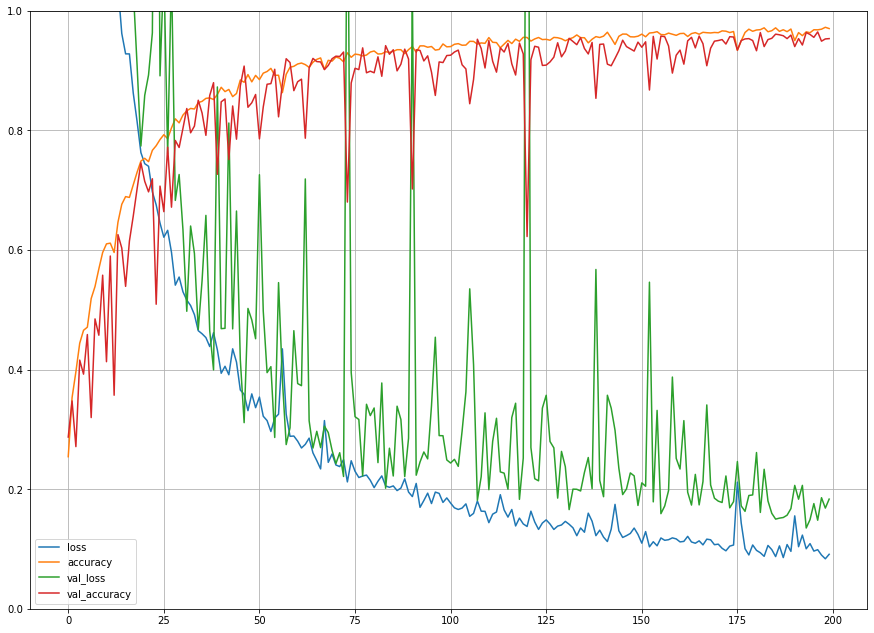

In [38]:
pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
# save the datagen for later use
with open("models/datagen_model_2_aug.pkl", "wb") as f:
    pickle.dump(datagen, f)

In [17]:
# load the datagen
with open("models/datagen_model_2_aug.pkl", "rb") as f:
    datagen_loaded = pickle.load(f)

X_test_normalized = datagen_loaded.standardize(X_test.astype(np.float32))

In [19]:
model_2_aug = keras.models.load_model("models/model_2_aug.h5")
model_2_aug.evaluate(X_test_normalized, y_test)

33/33 [==============================] - 2s 41ms/step - loss: 0.2596 - accuracy: 0.9212


[0.2595846652984619, 0.9212296009063721]

In [18]:
model_2_aug_ = keras.models.load_model("models/model_2_aug_best.h5")
model_2_aug_.evaluate(X_test_normalized, y_test)

33/33 [==============================] - 2s 41ms/step - loss: 0.3211 - accuracy: 0.9193


[0.321104496717453, 0.9193083643913269]

In [20]:
attrs.clear_session()

# Finalization